> ## Instituto Tecnológico y de Estudios Superiores de Monterrrey
>
> **Alumnos:**  Ariel Arturo Ortega Alegria [A01550829] Víctor Alfonso Rosales Soto [A01114509]

> **Equipo:** #40

> **Materia:** Proyecto Integrador

> **Modulo:** 5

> **Actividad:** Modelos Alternativos

> **Objetivo:** Evaluar una gama diversa de técnicas y enfoques con el fin de identificar el mejor desempeño con los datos , así como profundizar con la parametrización más óptima para cada uno de ellos. 


> **Fecha:** 22 de Febrero de 2026

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import psycopg2
import json
import warnings
warnings.filterwarnings('ignore')
#https://colab.research.google.com/drive/19tTaQfkpI6nrKpZGEmawpEVijvrrM55y?authuser=2#scrollTo=FZNjwKewd9fK

In [199]:

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import sklearn

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB



In [200]:
# --- Configuración para ver TODAS las columnas ---
pd.set_option('display.max_columns', None)

# --- Configuración adicional útil para ver todas las filas ---
pd.set_option('display.max_rows', None)

# --- Configuración para que las celdas largas no se corten ---
pd.set_option('display.max_colwidth', None)

In [201]:
#archivo con las credenciales para la conexion
with open('credentials_bd.json', 'r') as archivo:
    credenciales_yb = json.load(archivo)

# Parámetros de conexión a la base de datos PostgreSQL
db_params = {
    'database' : credenciales_yb['database'] ,
    'user' : credenciales_yb['user'],
    'password' : credenciales_yb['pasword'] ,  
    'host' : credenciales_yb['host'],
    'port' : credenciales_yb['port']
}
try:
    # Establecer una conexión a la base de datos
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()
    print("Conexión a la base de datos creada con éxito")
except psycopg2.Error as e:
    print(f"Error al conectar a la base de datos: {e}")


Conexión a la base de datos creada con éxito


In [202]:
consulta_sql = 'select * from recuperacion_credito."admin".Insumo2_ML where total_pagos >= 8 '

datos = pd.read_sql(consulta_sql, conn )

datos.head()

,idcte,edad,opc_genero,fec_alta,opc_escolaridad,fec_ultpago,imp_linea_cred,imp_linea_cred_real,imp_ingreso,clv_puesto,des_escolaridad,puntualidad,score_impago,nivel_riesgo,total_pagosmediosdigitales,total_pagos,frecuencia_digital_pct,ingreso,numerociudad,numerocolonia,nombreciudad,numeroestado,nombreestado,numerocalle,tipozona,cliente_conapp,cliente_soldigital,imp_montoingresomensual,cliente_cobranza,flag_clientedigital,total_comprasdigitales,total_comprasfisicas,perc_cuotadigitalventa
0,39283878,59.0,F,2016-08-05,3,2025-12-27,264022,112606,2,0,SECUNDARIA,A,316,11,0.0,9,0.0,2,106,5444,IZTACALCO,25,DISTRITO FEDERAL,143222,L,0,0,4000,1,0,3,36,7.69
1,40628303,42.0,M,2016-11-19,2,2025-12-24,159328,67954,4,1,PRIMARIA,A,290,5,0.0,8,0.0,4,339,450,VALLADOLID,30,YUCATAN,45020,F,0,0,7200,1,0,0,8,0.00
2,40629165,72.0,F,2016-12-07,0,2026-01-04,157380,67123,2,0,SIN DESCRIPCION,A,234,7,0.0,9,0.0,2,364,269,COSAMALOAPAN,23,VERACRUZ,452,L,0,0,4000,1,0,0,8,0.00
3,40635845,48.0,F,2016-12-16,3,2026-01-09,36110,15401,1,1,SECUNDARIA,A,279,2,0.0,16,0.0,1,139,10,PUERTO PE#ASCO,3,SONORA,87609,L,0,0,5000,1,0,1,17,5.55
4,40645854,28.0,M,2016-12-03,3,2026-01-10,163939,69920,2,1,SECUNDARIA,A,250,6,0.0,8,0.0,2,50,15,LAGOS DE MORENO,10,JALISCO,55238,L,0,0,4000,1,0,1,16,5.88


In [203]:
#Limpieza de datos y transformación de tipos de datos
# Reemplazar claves R y f, por F,
datos['tipozona'] = datos['tipozona'].str.replace('f', 'F')
datos['tipozona'] = datos['tipozona'].str.replace('R', 'F')

# Cambiamos el tipo de dato de integer a object
datos['clv_puesto'] = datos['clv_puesto'].astype(str)

# Quitamos claves de puesto que no son significativas y que en los últimos 10 años no se han utilizado para dar de alta las cuentas
datos = datos[datos['clv_puesto'].isin(['1', '2', '0', '4', '3', '5', '6', '40'])]

#Eliminamos los tipozona que no vienen bien desde el origen (nulls)
borrar_indice = datos[datos['tipozona'].isnull()].index
datos = datos.drop(borrar_indice)

In [204]:
datos = datos.dropna()

In [205]:
datos['fec_alta'] = pd.to_datetime(datos['fec_alta'])
diferencia_tiempo = datetime.now() - datos['fec_alta']
diferencia_en_dias = diferencia_tiempo.dt.days
datos['antiguedad_altacliente'] = np.floor(diferencia_en_dias / 365.25).astype(int)


datos_modelo = datos[['edad', 'imp_montoingresomensual', 'opc_escolaridad','opc_genero','antiguedad_altacliente','numeroestado',  'tipozona','cliente_conapp', 'cliente_soldigital','total_comprasdigitales','total_comprasfisicas','perc_cuotadigitalventa', 'flag_clientedigital']]

# 2 - Calcular el potencial digital por región donde se localiza el cliente
#Justificación : Se sospecha que de acuerdo a la ubicación física de los clientes y si éstos se localizan en zonas rurales o urbanas el nivel de digitalización varía
#Técnica empleada : Transformación de variables con alta cardinalidad al crear clusters de similitud utilizando como información la proporción de digitalización y diferencia de digitalización entre zonas rurales y urbanas.

# Generamos un catálogo con el nombre del estado y el identificador único
cat_estados = datos[['numeroestado', 'nombreestado']].drop_duplicates()

flag_clientedigital_0 = datos_modelo[datos_modelo['flag_clientedigital'] == 0]
flag_clientedigital_1 = datos_modelo[datos_modelo['flag_clientedigital'] == 1]

agrupado_digital_0 = flag_clientedigital_0[['numeroestado', 'tipozona', 'flag_clientedigital']].value_counts().reset_index(name='conteo')
agrupado_digital_0 = agrupado_digital_0.rename(columns = {'flag_clientedigital' : 'flag_clientedigital_0'})


agrupado_digital_1 =  flag_clientedigital_1[['numeroestado', 'tipozona', 'flag_clientedigital']].value_counts().reset_index(name='conteo')
agrupado_digital_1 = agrupado_digital_1.rename(columns = {'flag_clientedigital' : 'flag_clientedigital_1'})

# Creamos una llave única
agrupado_digital_1['llave'] = agrupado_digital_1['numeroestado'].astype(str) + "-" + agrupado_digital_1['tipozona']

agrupado_digital_0['llave'] = agrupado_digital_0['numeroestado'].astype(str) + "-" + agrupado_digital_0['tipozona']

# unimos las tablas para tener los datos en una sola tabla
agrupado_estados_zonas_digital = pd.merge(agrupado_digital_0,agrupado_digital_1, on = 'llave' )
agrupado_estados_zonas_digital['prop_ClientesDigitales'] = agrupado_estados_zonas_digital['conteo_y'] / (agrupado_estados_zonas_digital['conteo_x'] + agrupado_estados_zonas_digital['conteo_y'])

agrupado_estados_zonas_digital_resumida = agrupado_estados_zonas_digital[agrupado_estados_zonas_digital['tipozona_x'].isin(['L','F'])][['numeroestado_x', 'tipozona_x', 'conteo_x', 'conteo_y', 'prop_ClientesDigitales']].sort_values('numeroestado_x')

tabla_pivote_agrupado_est_zon_digital = agrupado_estados_zonas_digital_resumida.pivot(index='numeroestado_x', columns = 'tipozona_x', values = 'prop_ClientesDigitales')
tabla_pivote_agrupado_est_zon_digital = tabla_pivote_agrupado_est_zon_digital.reset_index().rename_axis(None, axis = 1)

# Calculamos los resultados entre diferencia de digitalizacion entre zonas foraneas y urbanas, así como el promedio de ambas .
tabla_pivote_agrupado_est_zon_digital['diferencia_entredigitalizacion'] = (tabla_pivote_agrupado_est_zon_digital['F'] - tabla_pivote_agrupado_est_zon_digital['L'])*100
tabla_pivote_agrupado_est_zon_digital['Promedio_Digitalizacion'] = (tabla_pivote_agrupado_est_zon_digital['F'] + tabla_pivote_agrupado_est_zon_digital['L']) / 2 

# Utilizamos una técnica de ML para encontrar las similitudes entre las regiones de México. Se decide crear inicialmente 4 cuadrantes de similitudes-------------------------------------------------------------------------------
# Aplicar algoritmo de Kmeans para calcular clusters de acuerdo al grado de digitalización y diferencia entre la digitalización de zonas foraneas y locales 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Elegir las columnas que se utilizarán para calcular los clusters
X = tabla_pivote_agrupado_est_zon_digital[['diferencia_entredigitalizacion', 'Promedio_Digitalizacion']]
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#2.1 - Escalar nuevos campos calculados para que la escala de los valores esté en un rango de 0 a 1 en ambas columnas, y ayude a la interpretación del algoritmo k-means.
#Justificación : Aplicamos técnica para estadarizar los datos para que funcione mejor el algoritmo ya que funciona con distancias. 
#Técnica empleada : Escalamiento de variables
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elegimos el número de clusters 
kmeans = KMeans(n_clusters=4, random_state = 42, n_init = 10)
kmeans.fit(X_scaled)

#Aplicamos etiqueta de Cluster generado a tabla Escalada
X['cluster'] = kmeans.labels_

#Aplicamos la etiqueta de Cluster a nuestra tabla principal. 
clusters_serie = pd.Series(kmeans.labels_, index = X.index)
tabla_pivote_agrupado_est_zon_digital['Cluster'] = clusters_serie

# Retornamos el nombre de los estados para poder dar lectura a los resultados. 

# Unir y eliminar la columna duplicada en un solo paso
resultado = pd.merge(
    tabla_pivote_agrupado_est_zon_digital, 
    cat_estados, 
    left_on='numeroestado_x', 
    right_on='numeroestado', 
    how='left'
).drop(columns=['numeroestado']) # Borramos la que viene del catálogo

# Para reducir dimensionalidad en la variable de Estado, aplicaremos una reducción calculando la media de diferencia de digitalización y promedio de digitalización  para cada cluster
# Para evitar que la columna estado se interprete erroneamente, se omitirá , en su lugar se pueden crear otro tipo manipulación de la información : 

#1- Agregar a los datos del modelo la información de Diferencia de digitalizacion y promedio de digitalización 
#2- Crear 4 variables nuevas utilizando el campo de Cluster con one hot encoding 
datos_modelo_1 = pd.merge(
    datos_modelo,
    resultado, 
    left_on= 'numeroestado',
    right_on='numeroestado_x',
    how='left'
).drop(columns=['numeroestado_x'])

#Datos #1
datos_modelo_1 = datos_modelo_1.drop([ 'F', 'L','numeroestado', 'nombreestado','diferencia_entredigitalizacion','Promedio_Digitalizacion', 'opc_genero'], axis=1)
datos_modelo_1.head()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
#2.2 Generamos una variable categorica ordinal a partir de la nueva variable generada con kmean, la cual nos dice la similitud de los estados de la república y se clasifica
# en estados de mayor y menor digitalización.
# Justificación - Hasta este momento el algoritmo k-means creó un variable no ordinal, la cual es complicada de leer en algoritmos de machine learning, por lo que para mejorar
# la interpretabilidad y que ésta tenga significado matemático, reclasificamos las etiquetas originales en valores numéricos ordinales.
# Técnica empleada: Crear nuevo campo con valores categóricos ordinales. 
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Definimos las condiciones (WHEN)
condiciones = [
    (datos_modelo_1['Cluster'] == 0),
    (datos_modelo_1['Cluster'] == 2),
    (datos_modelo_1['Cluster'] == 3),
    (datos_modelo_1['Cluster'] == 1)
]

# Definimos los resultados (THEN)
resultados = [1, 2, 3, 4]

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Aplicamos la variable de cluster ordinario
datos_modelo_1['Cluster_Ordinal'] = np.select(condiciones, resultados, default=0)

datos_modelo_1['AdopcionDigital_Antiguedad'] = datos_modelo_1['total_comprasdigitales'] / (datos_modelo_1['antiguedad_altacliente'] + 1)


datos_modelo_1['HabitosMixtosCompra'] = np.where((datos_modelo_1['total_comprasdigitales'] > 0) & (datos_modelo_1['total_comprasfisicas'] > 0), 1, 0 )

datos_modelo_1['HabitosCompraDigital'] = np.where((datos_modelo_1['total_comprasdigitales'] > 0) & (datos_modelo_1['total_comprasfisicas'] == 0 ), 1, 0 )

datos_modelo_1['MadurezDigital'] = ((datos_modelo_1['perc_cuotadigitalventa']> 0.5) + datos_modelo_1['cliente_soldigital'] + datos_modelo_1['cliente_conapp'])

datos_modelo_1['EdadActual'] = (datos_modelo_1['edad'] + datos_modelo_1['antiguedad_altacliente'])

In [ ]:
features = ['edad',
 'opc_escolaridad',
 'antiguedad_altacliente',
 'tipozona',
 'cliente_conapp',
 'cliente_soldigital',
 'total_comprasdigitales',
 'total_comprasfisicas',
 'Cluster_Ordinal',
 'HabitosMixtosCompra',
 'HabitosCompraDigital',
 'MadurezDigital']

### Inicia reto de la semana: 

Actividad : Construir múltiples modelos, ya sea individuales o no ensambles que sean relevantes para resolver el problema y evaluar sus desempeños. El propósito de la actividad radica en encontrar el modelo que genere el mejor rendimiento para nuestros datos.
Una vez seleccionado el mejorar buscar ajustar los hiperparámetros para optimizarlo. 

*A) Construír al menos 6 modelos diferentes* : https://colab.research.google.com/drive/19tTaQfkpI6nrKpZGEmawpEVijvrrM55y#scrollTo=B9i2CrLJs-1m

In [206]:
# Creamos los Conjuntos de Entrenamiento, validación y Prueba (OJO)

X = datos_modelo_1.drop(['flag_clientedigital', 'perc_cuotadigitalventa', 'EdadActual', 'Cluster', 'AdopcionDigital_Antiguedad', 'imp_montoingresomensual', 'tipozona' ], axis=1)

y = datos_modelo_1['flag_clientedigital']

In [207]:
Xtrain, Xtemp, ytrain, ytemp = train_test_split(X,y, train_size = 0.7, test_size = 0.30, random_state=1, stratify=y)

Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, test_size= 0.5, random_state=1)

In [208]:
Xtrain.head()

,edad,opc_escolaridad,antiguedad_altacliente,cliente_conapp,cliente_soldigital,total_comprasdigitales,total_comprasfisicas,Cluster_Ordinal,HabitosMixtosCompra,HabitosCompraDigital,MadurezDigital
69298,22.0,4,3,0,0,1,14,3,1,0,1
11040,37.0,6,0,0,0,0,23,4,0,0,0
36165,20.0,4,2,1,1,0,17,3,0,0,2
3131,38.0,5,7,1,0,2,5,1,1,0,2
72973,28.0,3,8,1,0,1,6,4,1,0,2


In [209]:
Xtrainval = pd.concat([Xtrain,Xval], axis = 0, ignore_index = True)
ytrainval = pd.concat([ytrain,yval], axis = 0, ignore_index = True)

Xtrainval_sinescalar = pd.concat([Xtrain,Xval], axis = 0, ignore_index = True)
ytrainval_sinescalar = pd.concat([ytrain,yval], axis = 0, ignore_index = True)

### Pruebas en algoritmos geométricos que utilizan las distancias para clasificar

-   Regresión Logística

-   MLP

-   K Nearest Neighbors

##### Eliminamos el ruido que pudiera generarse al tener un dataset con campos numéricos de diferente escala. Para lo anterior, utilizamos la técnica de escalado Min-Max para distribuir todos los valores de los campos entre 0 y 1.

In [210]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

# Transformación tipo min max scalling para algoritmos que funcionan con distancias
num_pipe = Pipeline(steps=[('escalar', MinMaxScaler(feature_range = (0,1))) ] )
num_pipe_nombres = ['edad', 'total_comprasdigitales' , 'total_comprasfisicas', 'opc_escolaridad' , 'antiguedad_altacliente', 'Cluster_Ordinal', 'MadurezDigital']

columnas_Transformadas = ColumnTransformer(
    transformers=[
        ('procesamiento_Col_numericas' , num_pipe , num_pipe_nombres  )
    ],
    remainder= 'passthrough'
)

In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
import numpy as np

# 1. Definimos la función
def mis_modelos(): 
    modelos, nombres_modelos = list(), list()

    # 1) Regresión Logística
    modelos.append(LogisticRegression(max_iter=1000, C=1.0)) 
    nombres_modelos.append('LR')

    # 2) Perceptrón Multicapa
    modelos.append(MLPClassifier(hidden_layer_sizes=(30,),     # 100,  6, 24, 30, (15,15), (50,50)
                               activation='logistic',
                               max_iter=1000,                  # 200,
                               alpha=0.0001,               # término de regularización L2.
                               #learning_rate='constant',       # tasa de aprendizaje o tamaño de paso del método Gradiente Descendente.
                               #learning_rate_init=0.001,
                               #random_state=1
                               ))
    nombres_modelos.append('MLP')

    # 3) k-Nearest Neighbors
    modelos.append(KNeighborsClassifier(n_neighbors= 5))
    nombres_modelos.append('KNN')

    return modelos, nombres_modelos


# 2. Llamamos a la función para obtener las listas
modelos, nombres = mis_modelos()
resultados = list()

# 3. Iniciamos el ciclo de evaluación
for i in range(len(modelos)):

    # Creamos el pipeline con el modelo actual
    pipeline = Pipeline(steps=[('ct', columnas_Transformadas) , ('m', modelos[i])])

    # Configuración de la validación cruzada
    micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=5)
    
    # Definimos métricas
    mismetricas = ['accuracy', 'precision', 'recall', 'f1']

    # Ejecutamos cross_validate
    scores = cross_validate(pipeline,
                             Xtrainval,
                             ytrainval,
                             scoring=mismetricas,
                             cv=micv,
                             return_train_score=True)
    
    resultados.append(scores)

    # 4. Impresión de resultados
    print('>> %s' % nombres[i])
    for k, v in scores.items():
        # Filtramos para mostrar solo las métricas de test (validación)
        if k.startswith('test_'):
            print('\t %s: %.3f (%.3f)' % (k, np.mean(v), np.std(v)))

>> LR
	 test_accuracy: 0.801 (0.003)
	 test_precision: 0.583 (0.018)
	 test_recall: 0.216 (0.010)
	 test_f1: 0.315 (0.012)
>> MLP
	 test_accuracy: 0.809 (0.003)
	 test_precision: 0.629 (0.013)
	 test_recall: 0.240 (0.020)
	 test_f1: 0.347 (0.021)
>> KNN
	 test_accuracy: 0.775 (0.003)
	 test_precision: 0.451 (0.011)
	 test_recall: 0.280 (0.008)
	 test_f1: 0.345 (0.008)


### Pruebas en algoritmos geométricos que no utilizan las distancias para clasificar

- Árbol de Decisión

- Bosques Aleatorio

- Perceptrón Multicapa

- NaiveBayes

In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
import numpy as np

# 1. Definimos la función
def mis_modelos(): 
    modelos, nombres_modelos = list(), list()

    # 1) Regresión Logística
    #modelos.append(LogisticRegression(max_iter=1000, C=1.0 , class_weight= 'balanced')) 
    #nombres_modelos.append('LR')

    modelos.append(LogisticRegression()) 
    nombres_modelos.append('LR')

    # 2) Árbol de Decisión

     #modelos.append(DecisionTreeClassifier(class_weight='balanced', max_depth= 2, criterion= 'gini', min_samples_split= 3))
    #nombres_modelos.append('DTree')

    modelos.append(DecisionTreeClassifier(max_depth= 2, min_samples_split= 3))
    nombres_modelos.append('DTree')

    # 3) Bosques Aleatorio
    #modelos.append(RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth = 2, criterion = 'gini', min_samples_split = 3))
    #nombres_modelos.append('RF')

    modelos.append(RandomForestClassifier(n_estimators=100,  max_depth = 2 , min_samples_split = 3))
    nombres_modelos.append('RF')

    # 4) Perceptrón Multicapa
    #modelos.append(MLPClassifier(hidden_layer_sizes=(30,),     # 100,  6, 24, 30, (15,15), (50,50)
    #                           activation='logistic',
    #                           max_iter=1000,                  # 200,
    #                           alpha=0.0001,               # término de regularización L2.
                               #learning_rate='constant',       # tasa de aprendizaje o tamaño de paso del método Gradiente Descendente.
                               #learning_rate_init=0.001,
                               #random_state=1
    #                           ))
    #nombres_modelos.append('MLP')

    modelos.append(MLPClassifier(     # 100,  6, 24, 30, (15,15), (50,50)
                               activation='logistic',
                               max_iter=1000           # término de regularización L2.
                               #learning_rate='constant',       # tasa de aprendizaje o tamaño de paso del método Gradiente Descendente.
                               #learning_rate_init=0.001,
                               #random_state=1
                               ))
    nombres_modelos.append('MLP')

    # 5) Maquina de Soporte Vectoriales
    #modelos.append(LinearSVC(class_weight='balanced', C = 1.0, max_iter = 10000))
    #nombres_modelos.append('LinearSVM')

    modelos.append(LinearSVC( C = 1.0, max_iter = 10000))
    nombres_modelos.append('LinearSVM')


    # 6 NaiveBayes
    modelos.append(GaussianNB())
    nombres_modelos.append('GNB') 

    return modelos, nombres_modelos


# 2. Llamamos a la función para obtener las listas
modelos, nombres = mis_modelos()
resultados = list()

# 3. Iniciamos el ciclo de evaluación
for i in range(len(modelos)):

    # Creamos el pipeline con el modelo actual
    pipeline = Pipeline(steps=[('m', modelos[i])])

    # Configuración de la validación cruzada
    micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=5)
    
    # Definimos métricas
    mismetricas = ['accuracy', 'precision', 'recall', 'f1']

    # Ejecutamos cross_validate
    scores = cross_validate(pipeline,
                             Xtrainval,
                             ytrainval,
                             scoring=mismetricas,
                             cv=micv,
                             return_train_score=True)
    
    resultados.append(scores)

    # 4. Impresión de resultados
    print('>> %s' % nombres[i])
    for k, v in scores.items():
        # Filtramos para mostrar solo las métricas de test (validación)
        if k.startswith('test_'):
            print('\t %s: %.3f (%.3f)' % (k, np.mean(v), np.std(v)))

>> LR
	 test_accuracy: 0.804 (0.002)
	 test_precision: 0.593 (0.014)
	 test_recall: 0.244 (0.007)
	 test_f1: 0.346 (0.008)
>> DTree
	 test_accuracy: 0.800 (0.003)
	 test_precision: 0.588 (0.029)
	 test_recall: 0.200 (0.018)
	 test_f1: 0.297 (0.017)
>> RF
	 test_accuracy: 0.788 (0.000)
	 test_precision: 0.050 (0.187)
	 test_recall: 0.000 (0.000)
	 test_f1: 0.000 (0.001)
>> MLP
	 test_accuracy: 0.814 (0.004)
	 test_precision: 0.634 (0.028)
	 test_recall: 0.292 (0.026)
	 test_f1: 0.398 (0.020)
>> LinearSVM
	 test_accuracy: 0.804 (0.002)
	 test_precision: 0.618 (0.020)
	 test_recall: 0.192 (0.006)
	 test_f1: 0.293 (0.009)
>> GNB
	 test_accuracy: 0.781 (0.003)
	 test_precision: 0.479 (0.009)
	 test_recall: 0.358 (0.013)
	 test_f1: 0.409 (0.010)


Nota: A pesar de que la regla básica para utilizar modelos ML que funcionan a través de distancias como; Regresión Logística y Perceptrón Multicapa, nos indica que se requiere el escalamiento en los predictores numéricos,  tras probar los modelos con y sin escalamiento,  encontramos que al escalar los datos numéricos se perdió la jerarquía natural que ayudaba a los modelos a distinguir la clase positiva, por lo que se decidió utilizar los modelos sin transformación. 

*B) Comparar el rendimiento de los modelos obtenidos*

##### Midiendo el Recall 

In [220]:
modelos, nombres_modelos = mis_modelos()
resultados = list()

mismetricas = ['recall']

datos_boxplot = []

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('m', modelos[i])])

    micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=5)

    scores = cross_validate(pipeline, Xtrainval_sinescalar, ytrainval_sinescalar, scoring=mismetricas, cv=micv, return_train_score=True)

    resultados.append(scores)

    for j, k in enumerate(scores.keys()):
        if j > 1:  # Ignoramos 'fit_time' y 'score_time'
            mean_score = round(np.mean(scores[k]),3)
            datos_boxplot.append((nombres_modelos[i], k, mean_score))
            print(f'\t{k} (%.3f)' % mean_score)

datos_boxplot_Df_recall = pd.DataFrame(datos_boxplot, columns=['Modelo', 'Metricas', 'Valor_Promedio'])

	test_recall (0.244)
	train_recall (0.244)
	test_recall (0.200)
	train_recall (0.201)
	test_recall (0.000)
	train_recall (0.000)
	test_recall (0.298)
	train_recall (0.299)
	test_recall (0.192)
	train_recall (0.192)
	test_recall (0.358)
	train_recall (0.358)


In [221]:
datos_boxplot_Df_recall.sort_values(by = ['Valor_Promedio','Modelo'], ascending= False)

,Modelo,Metricas,Valor_Promedio
10,GNB,test_recall,0.358
11,GNB,train_recall,0.358
7,MLP,train_recall,0.299
6,MLP,test_recall,0.298
0,LR,test_recall,0.244
1,LR,train_recall,0.244
3,DTree,train_recall,0.201
2,DTree,test_recall,0.200
8,LinearSVM,test_recall,0.192
9,LinearSVM,train_recall,0.192


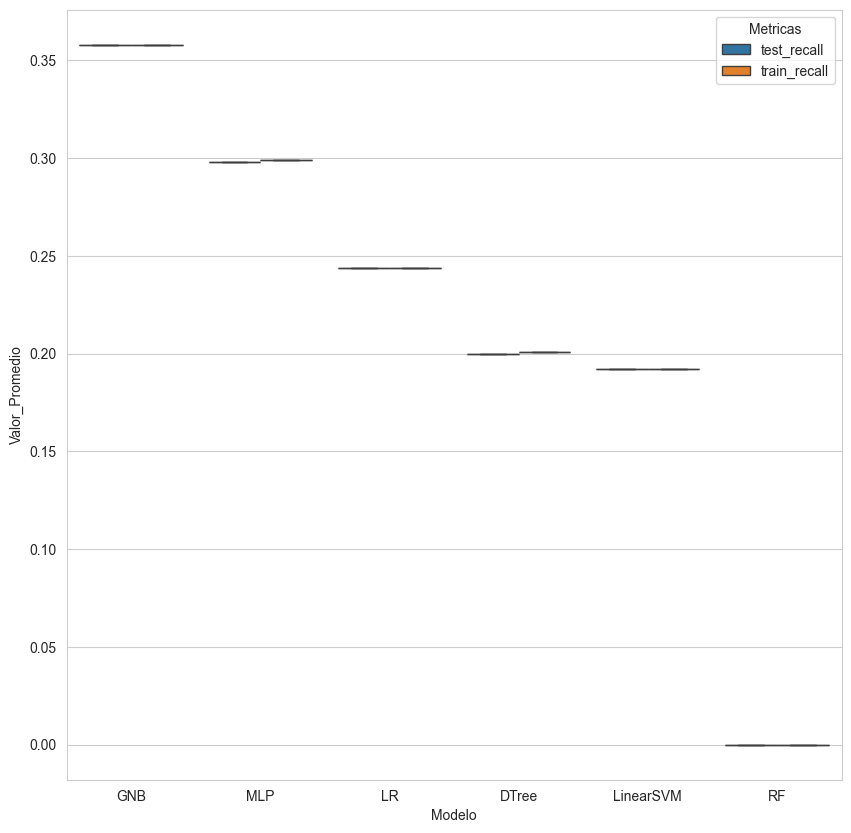

In [223]:
orden_modelos = datos_boxplot_Df_recall.groupby("Modelo")["Valor_Promedio"].median().sort_values(ascending=False).index
plt.figure(figsize= (10,10))
sns.boxplot(x ='Modelo', y = 'Valor_Promedio', hue = 'Metricas', data =datos_boxplot_Df_recall, order = orden_modelos  )
plt.show()

##### Midiendo la precisión

In [224]:
modelos, nombres_modelos = mis_modelos()
resultados = list()

mismetricas = ['precision']

datos_boxplot = []

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('m', modelos[i])])

    micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=5)

    scores = cross_validate(pipeline, Xtrainval_sinescalar, ytrainval_sinescalar, scoring=mismetricas, cv=micv, return_train_score=True)

    resultados.append(scores)

    for j, k in enumerate(scores.keys()):
        if j > 1:  # Ignoramos 'fit_time' y 'score_time'
            mean_score = round(np.mean(scores[k]),3)
            datos_boxplot.append((nombres_modelos[i], k, mean_score))
            print(f'\t{k} (%.3f)' % mean_score)

datos_boxplot_Df_precision = pd.DataFrame(datos_boxplot, columns=['Modelo', 'Metricas', 'Valor_Promedio'])

	test_precision (0.593)
	train_precision (0.593)
	test_precision (0.588)
	train_precision (0.591)
	test_precision (0.190)
	train_precision (0.168)
	test_precision (0.633)
	train_precision (0.636)
	test_precision (0.618)
	train_precision (0.618)
	test_precision (0.479)
	train_precision (0.479)


In [225]:
datos_boxplot_Df_precision.sort_values(by = ['Valor_Promedio' , 'Modelo'], ascending= False)

,Modelo,Metricas,Valor_Promedio
7,MLP,train_precision,0.636
6,MLP,test_precision,0.633
8,LinearSVM,test_precision,0.618
9,LinearSVM,train_precision,0.618
0,LR,test_precision,0.593
1,LR,train_precision,0.593
3,DTree,train_precision,0.591
2,DTree,test_precision,0.588
10,GNB,test_precision,0.479
11,GNB,train_precision,0.479


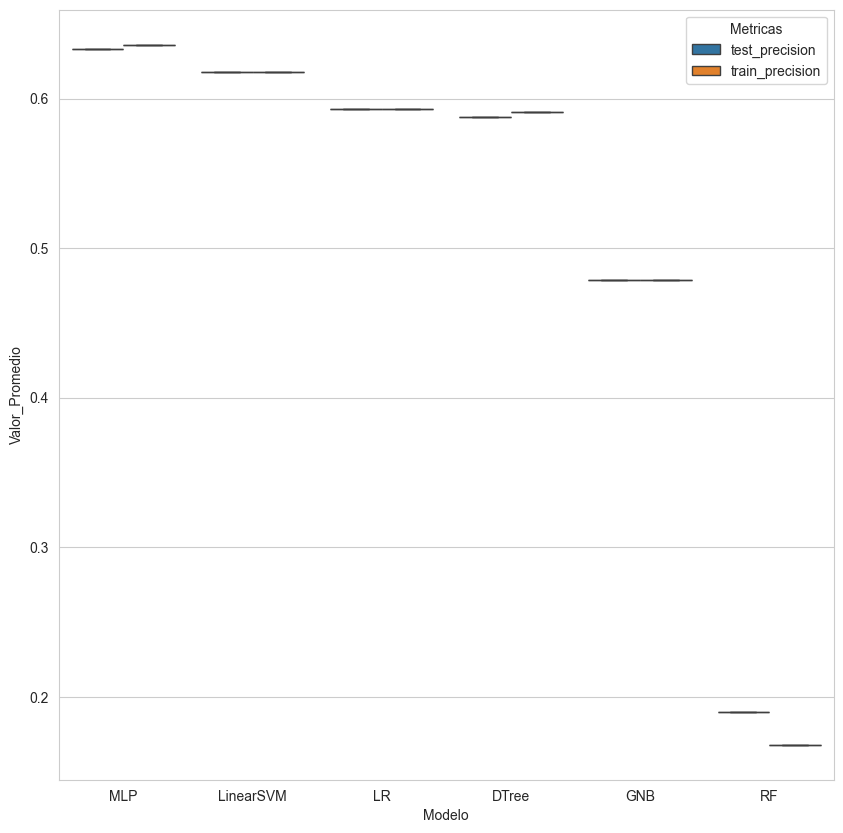

In [226]:
orden_modelos = datos_boxplot_Df_precision.groupby("Modelo")["Valor_Promedio"].median().sort_values(ascending=False).index
plt.figure(figsize= (10,10))
sns.boxplot(x ='Modelo', y = 'Valor_Promedio', hue = 'Metricas', data =datos_boxplot_Df_precision, order = orden_modelos  )
plt.show()

*C) Selección de los mejores modelos*

#### - GNB
#### - MLP

Tras aplicar la técnica de validación cruzada utilizando los hiperparámetros por defecto (modelos base), se observó que los algoritmos Gaussian Naive Bayes (GNB) y Multi-Layer Perceptron (MLP) superaron al resto de los modelos en la métrica de recall. Estos resultados se deben a que ambos algoritmos no trabajan con fronteras de decisión lineales y rígidas. Esta flexibilidad les permitió identificar patrones en la clase minoritaria de manera más efectiva que los modelos lineales sin configurar, los cuales tendieron a sesgarse hacia la clase mayoritaria debido al desbalance de los datos.

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1. Entrenamos el modelo final con los mejores parámetros encontrados
modelo_final_GNB = GaussianNB()
modelo_final_GNB.fit(Xtrainval, ytrainval)

y_predGNB = modelo_final_GNB.predict(Xtest)

resultados_GNB_inicial = classification_report(ytest,y_predGNB )


In [249]:
print(resultados_GNB_inicial)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      8862
           1       0.49      0.37      0.42      2467

    accuracy                           0.78     11329
   macro avg       0.66      0.63      0.64     11329
weighted avg       0.76      0.78      0.77     11329



In [234]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1. Entrenamos el modelo seleccionado con los mismos parámetros pero sin utilizar técnica de validación cruzada. 
modelo_final_MLP = MLPClassifier(   
                               activation='logistic',
                               max_iter=1000        
                               )
modelo_final_MLP.fit(Xtrainval, ytrainval)

# 2. Predecimos la variable a predecir con conjunto de Test. 
y_pred = modelo_final_MLP.predict(Xtest)

# 3. Guardamos las métricas de resultados
resultados_MLP_inicial = classification_report(ytest, y_pred)





In [237]:
print(resultados_MLP_inicial)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      8862
           1       0.65      0.29      0.40      2467

    accuracy                           0.81     11329
   macro avg       0.74      0.62      0.65     11329
weighted avg       0.79      0.81      0.78     11329



*D) Ajustar hiperparámetros de modelos seleccionada*

#### Ajuste de los Modelos
La fase de optimización se ejecutará mediante Grid Search, explorando de forma exhaustiva las combinaciones de hiperparámetros sugeridas por la literatura para cada arquitectura. Se configurarán rangos específicos para los parámetros cuantitativos y catálogos de opciones para los cualitativos.

#### Justificación de la Métrica de Éxito
Dado que el objetivo es clasificar correctamente a la mayor cantidad de clientes digitales preservando la exactitud de la clasificación, se adoptará la métrica F1 como función objetivo. Al ser la media armónica entre Precision y Recall, el F1-Score asegura que el modelo final no presente sesgos hacia ninguna de estas dos métricas en detrimento de la otra. 

In [239]:
from sklearn.model_selection import GridSearchCV


param_grid_mlp = [
   {
    'hidden_layer_sizes': [(50,), (100,)], # Pocas neuronas para rapidez
    'alpha': [0.0001, 0.01],              # Dos extremos de regularización
    'learning_rate_init': [0.001, 0.01]    # Velocidad estándar vs rápida
    }]

grid_mlp = GridSearchCV(MLPClassifier(activation='logistic', max_iter=1000) , param_grid_mlp, cv=5, scoring='f1')
grid_mlp.fit(Xtrainval, ytrainval)

print("Mejores parámetros:", grid_mlp.best_params_)

Mejores parámetros: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}


In [252]:
from sklearn.model_selection import GridSearchCV

param_grid_GNB= [
    {
       'var_smoothing': np.logspace(0, -9, num=10)
    }]

grid_GNB = GridSearchCV(GaussianNB(), param_grid_GNB, cv=5, scoring='f1')
grid_GNB.fit(Xtrainval, ytrainval)

print("Mejores parámetros:", grid_GNB.best_params_)

Mejores parámetros: {'var_smoothing': np.float64(0.0001)}


#### Ajustamos los modelos con los hiperparametros recomendados con GridSearch

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

#{'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}

# 1. Entrenamos el modelo seleccionado con los mismos parámetros pero sin utilizar técnica de validación cruzada. 
modelo_final_MLP = MLPClassifier(activation='logistic', max_iter=1000, alpha = 0.0001, hidden_layer_sizes=(100,) , learning_rate_init =0.001 )
modelo_final_MLP.fit(Xtrainval, ytrainval)

# 2. Predecimos la variable a predecir con conjunto de Test. 
y_pred_ajustado = modelo_final_MLP.predict(Xtest)

# 3. Guardamos las métricas de resultados
resultados_MLP_ajustado = classification_report(ytest, y_pred_ajustado)




In [243]:
print(resultados_MLP_ajustado)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      8862
           1       0.62      0.34      0.44      2467

    accuracy                           0.81     11329
   macro avg       0.73      0.64      0.66     11329
weighted avg       0.79      0.81      0.79     11329



In [254]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# {'var_smoothing': np.float64(0.0001)}

# 1. Entrenamos el modelo final con los mejores parámetros encontrados
modelo_final_GNB = GaussianNB(var_smoothing=0.0001)
modelo_final_GNB.fit(Xtrainval, ytrainval)

y_predGNB = modelo_final_GNB.predict(Xtest)

resultados_GNB_ajustado = classification_report(ytest,y_predGNB )


In [255]:
print(resultados_GNB_ajustado)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      8862
           1       0.48      0.43      0.46      2467

    accuracy                           0.78     11329
   macro avg       0.66      0.65      0.66     11329
weighted avg       0.77      0.78      0.77     11329



*E) Elegir modelo ganador*

#### - Multi Layer Perceptron (MLP)

Justificación : 

El desempeño del MLP resultó sobresaliente desde la creación del baseline, modelando con mayor precisión las relaciones no lineales del dataset que sus contrapartes. En su estado inicial, obtuvo un recall de 30% y una precisión de 63%. La fase de refinamiento técnico permitió desplazar la frontera de decisión para favorecer la sensibilidad del modelo, esto resultó en un incremento del recall a 34% con una degradación mínima en la precisión, la cual se situó en 62%. Este intercambio (trade-off) se considera óptimo para los objetivos de rentabilidad del proyecto. 

Desde la perspectiva de negocio, la preferencia por el algoritmo Multi-Layer Perceptron (MLP) se fundamenta en la asimetría de costos operativos. Dado que la gestión tradicional es al menos cinco veces más costosa que la digital, el error de clasificar erróneamente a un cliente como 'no digital' representa un impacto financiero significativo. Bajo esta premisa, se priorizó la precisión del MLP (superior a GNB) por sobre el recall. Aunque el modelo abarca un volumen menor de la población digital, garantiza una mayor certidumbre en la asignación, optimizando el recurso humano al concentrarlo en casos de alta probabilidad de éxito y manteniendo un equilibrio saludable con el volumen de clientes gestionados.

Los resultados obtenidos hasta este momento nos ayudan a concluir que la calidad del preprocesamiento de datos, así como del mismo dataset que se ha creado para el reto de clasificación de clientes digitales, ha facilitado la obtención de métricas de negocio accionables desde las primeras iteraciones. No obstante, el modelo actual manifiesta limitaciones en la sensibilidad para identificar la totalidad de la muestra objetivo.

 A fin de mitigar este sesgo, se propone la transición hacia algoritmos de Gradient Boosting, con el objetivo de optimizar la frontera de decisión. Se proyecta que el uso de XGBoost y la técnica de validación cruzada permitirá elevar el Recall. El nuevo reto será explorar algoritmos de ensamble que ayuden al menos a aumentar 6 puntos en la métrica de recall, sin castigar demasiado a la métrica objetivo. 